<a href="https://colab.research.google.com/github/borankilic/NV_center/blob/main/NV_center_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning Utilization for Sensitive Magnetic Field Detection from Emission Spectrum of NV Centers

## Import and Plot

In [ ]:
# @title import required libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.signal import find_peaks
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.ticker import MaxNLocator
from sklearn.preprocessing import MinMaxScaler
#!pip install GPy --quiet
#!pip install specutils --quiet


In [ ]:
# @title Helper Functions
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def plot_emission_spectrum(signal_array, total_duration, start_time, stop_time, second_array = 0, scatter = False):
    """
    Plots the oscilloscope output of an emission spectrum over a specified time interval.

    Parameters:
    - signal_array: np.array, the emission spectrum data.
    - total_duration: float, total time duration of the signal (in seconds).
    - start_time: float, starting time of the interval to be plotted (in seconds).
    - stop_time: float, stopping time of the interval to be plotted (in seconds).
    - second_array: np.array, voltage on Helmotz coil (if provided)

    Output:
    - A Seaborn line plot for the given time window.
    """
    # Calculate the time step based on total duration and array size
    time_step = total_duration / len(signal_array)

    # Create a time array corresponding to the signal_array
    time_array = np.arange(0, total_duration, time_step)[:len(signal_array)]

    # Select the interval indices for the specified start and stop times
    start_idx = int(start_time / time_step)
    stop_idx = int(stop_time / time_step)

    # Extract the portion of the signal and time arrays for the interval
    interval_time = time_array[start_idx:stop_idx]
    interval_signal = signal_array[start_idx:stop_idx]

    # Plot the signal using Seaborn
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    fig, ax1 = plt.subplots(figsize=(10, 6))
    if  not scatter:
        sns.lineplot(x=interval_time, y=interval_signal, color="blue", linewidth=0.5)
    else:
        sns.scatterplot(x=interval_time, y=interval_signal, color="blue", linewidth=0.5)
    ax1.set_xlabel("Time (seconds)")
    ax1.set_ylabel("Amplitude 1", color="blue")
    ax1.tick_params(axis='y', labelcolor="blue")

    if not np.any(second_array) == 0:

        ax2 = ax1.twinx()
        # Plot the second signal on the secondary y-axis
        ax2.set_ylabel("Amplitude 2", color="red")
        ax2.tick_params(axis='y', labelcolor="red")
        interval_second =  second_array[start_idx:stop_idx]
        sns.lineplot(x=interval_time, y=interval_second, color="red", linewidth=0.5)

    plt.title(f"Emission Spectrum from {start_time}s to {stop_time}s")
    plt.show()
def normalize_rows_min_max(arr):
    # Apply min-max normalization to each row
    arr_min = arr.min(axis=1, keepdims=True)
    arr_max = arr.max(axis=1, keepdims=True)
    return (arr - arr_min) / (arr_max - arr_min)


def plot_voltages(v1,v2, t1, t2, linew=0.05):
    fig, ax1 = plt.subplots()

    fig.set_size_inches(20, 6)
    # Plot on the first y-axis
    ax1.plot(np.arange(0,len(v1)/1000,0.001)[int(t1*1000):int(t2*1000)], v1[int(t1*1000):int(t2*1000)], linewidth = linew, color='blue')
    ax1.set_xlabel('time(s)')
    ax1.set_ylabel('Ch_1', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=40))


    # Create a second y-axis that shares the same x-axis
    ax2 = ax1.twinx()
    ax2.plot(np.arange(0,len(v2)/1000,0.001)[int(t1*1000):int(t2*1000)], v2[int(t1*1000):int(t2*1000)], linewidth = linew, color='red')
    ax2.set_ylabel('Ch_2', color='r')
    ax2.tick_params(axis='y', labelcolor='r')


def plot_random_peaks(peaks, b_vals, linew=1):
    idxs = np.random.randint(0, len(peaks), 2)
    v1, v2 = peaks[idxs]
    b1, b2 = b_vals[idxs]

    fig, ax1 = plt.subplots()
    fig.set_size_inches(20, 6)

    # Plot the first peak
    ax1.plot(np.arange(0, len(v1), 1), v1, linewidth=linew, color='blue', label=f'Peak 1, B_value: {b1}')
    ax1.set_xlabel('time(s)')
    ax1.set_ylabel('Ch_1', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=40))

    # Create a second y-axis for the second peak
 #   ax2 = ax1.twinx()
    ax1.plot(np.arange(0, len(v2), 1), v2, linewidth=linew, color='red', label=f'Peak 2, B_value: {b2}')
 #   ax2.set_ylabel('Ch_2', color='r')
 #   ax2.tick_params(axis='y', labelcolor='r')
 #   ax2.xaxis.set_major_locator(MaxNLocator(nbins=40))

    # Add legends for both plots
    ax1.legend(loc='lower right')
  #  ax2.legend(loc='lower right')

    plt.title('Random Peaks with Corresponding B_values')
    plt.show()

# Example usage (ensure you have peaks and b_vals arrays to use):
# peaks = np.array([...])
# b_vals = np.array([...])
# plot_random_peaks(peaks, b_vals)

# @title helper functions
def acc(pred,label):
  pred = torch.round(pred.squeeze(), decimals=1)
  label = torch.round(label.squeeze(), decimals=1)
  return torch.sum(pred == label.squeeze()).item()


# Train for a number of Epochs
def train_model(model, train_loader, valid_loader, epochs, criterion, optimizer,  device = device):
  # Initial Loss value (assumed big)
  valid_loss_min = np.inf

  # Lists to follow the evolution of the loss and accuracy
  epoch_tr_loss,epoch_vl_loss = [],[]
  epoch_tr_acc,epoch_vl_acc = [],[]

  # Train for a number of Epochs
  for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()

    for inputs, labels in train_loader:


      # Move batch inputs and labels to gpu
      inputs, labels = inputs.to(device), labels.to(device)


      # Zero out the gradient
      optimizer.zero_grad()

      # Set gradient to zero
      #model.zero_grad()

      # Compute model output
      output = model(inputs)

      # Calculate the loss and perform backprop
      loss = criterion(output.squeeze(), labels)
      #loss.requires_grad = True
      loss.backward()
      train_losses.append(loss.item())

      # calculating accuracy
      accuracy = acc(output,labels)
      train_acc += accuracy

      optimizer.step()


    # Evaluate on the validation set for this epoch
    labels_lst = []
    preds_lst = []
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:


      # Move batch inputs and labels to gpu
      inputs, labels = inputs.to(device), labels.to(device)

      # Compute model output
      output = model(inputs)

      # Compute Loss
      val_loss = criterion(output.squeeze(), labels)

      pred = output.squeeze()
      preds_lst.append(pred)
      labels_lst.append(labels)
      # Calculate Accuracy
      val_losses.append(val_loss.item())

      accuracy = acc(output,labels)
      val_acc += accuracy

    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}')
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
      print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
      # torch.save(model.state_dict(), '../working/state_dict.pt')
      valid_loss_min = epoch_val_loss
    print(25*'==')
  return epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss, preds_lst, labels_lst

def plot_loss_acc(epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss):
  fig = plt.figure(figsize = (20, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epoch_tr_acc, label='Train Acc')
  plt.plot(epoch_vl_acc, label='Validation Acc')
  plt.title("Accuracy")
  plt.legend()
  plt.grid()

  plt.subplot(1, 2, 2)
  plt.plot(epoch_tr_loss, label='Train loss')
  plt.plot(epoch_vl_loss, label='Validation loss')
  plt.title("Loss")
  plt.legend()
  plt.grid()

  plt.show()

def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss


Load in peaks and their corresponding magnetic field values. Load peaks.npy file where each row in the array contains a spectrum. Also load in b_vals.npy file where each entry is the corresponding magnetic field value of the spectrum at the given index. It also concatanates spectrums and b_vals if multiple files are loaded. DO NOT FORGET TO EDIT THE NAME OF THE FILES AND # OF FILES.

In [ ]:
#Uncomment below to load multiple arrays at the same time
'''
spec_lst = []
b_lst = []
for i in range(1,4):
  peaks = np.load(f'peaks_tgthr_maf_peaks_{i}.npy')
  b_vals = np.load(f'peaks_tgthr_maf_B_vals_{i}.npy')
  spec_lst.append(peaks)
  b_lst.append(b_vals)
  print(peaks.shape)'''

peaks = np.load(f'11.10_int_peaks.npy')
b_vals = np.load(f'11.10_int_B_vals.npy')

peaks.shape, b_vals.shape
plot_random_peaks(peaks,b_vals)

FileNotFoundError: [Errno 2] No such file or directory: '11.10_int_peaks.npy'

In [ ]:
# @title normalize voltages to prevent expoding or vanishing gradients problem
peaks_scaled = normalize_rows_min_max(peaks) # turn them upside down
plot_random_peaks(peaks_scaled,b_vals)

NameError: name 'peaks' is not defined

## GAUSSIAN PROCESS REGRESSION

Gaussian Process Regression (GPR) is a non-parametric, Bayesian approach to regression. It assumes that the data points are sampled from a multivariate Gaussian distribution and uses this assumption to predict continuous values. GPR models the relationship between inputs and outputs as a distribution over functions, rather than assuming a fixed functional form.

GPR optimizes the kernel hyperparameters to achieve a balance between data fit and model complexity, allowing it to predict both the mean function and uncertainty.

In [ ]:
import torch
import GPy

Y = peaks_scaled[2]
X = np.arange(0,len(Y), 1)

Q = X.shape[-1]
k = GPy.kern.RBF(1, variance=300)
m = GPy.models.GPRegression(X=X.reshape(-1,1), Y=Y.reshape(-1,1) , kernel=k)
m.optimize(messages=1)
print(m)
m.plot()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/paramz/model.py", line 111, in optimize
    opt.run(start, f_fp=self._objective_grads, f=self._objective, fp=self._grads)
  File "/usr/local/lib/python3.10/dist-packages/paramz/optimization/optimization.py", line 51, in run
    self.opt(x_init, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/paramz/optimization/optimization.py", line 124, in opt
    opt_result = optimize.fmin_l_bfgs_b(f_fp, x_init, maxfun=self.max_iters, maxiter=self.max_iters, **opt_dict)
  File "/usr/local/lib/python3.10/dist-packages/scipy/optimize/_lbfgsb_py.py", line 237, in fmin_l_bfgs_b
    <= gtol`` where ``proj g_i`` is the i-th component of the
  File "/usr/local/lib/python3.10/dist-packages/scipy/optimize/_lbfgsb_py.py", line 407, in _minimize_lbfgsb
    njev=sf.ngev,
  File "/usr/local/lib/python3.10/dist-packages/scipy/optimize/_differentiable_functions.py", line 296, in fun_and_grad
    self._update_fun()
  File "

TypeError: object of type 'NoneType' has no len()

## Curve Fitting

### Gaussian Fitting

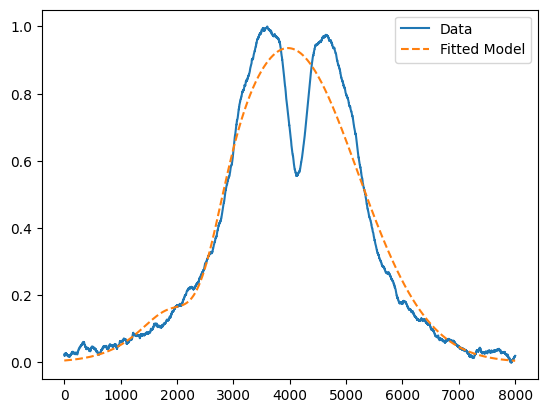

-0.18312990247247377 2415.1842453675495 368.0089227640086 0.9351696210780038 3968.75678027095 1234.1709052374551 0.0005248727368741864


In [ ]:
# @title Fit the spectrum to sum of 2 Gaussians (+ a bias parameter)

from astropy.modeling import Fittable1DModel, Parameter
from astropy.modeling.fitting import LevMarLSQFitter

class GaussianWithBias(Fittable1DModel):
    # Define the parameters for the model
    amplitude1 = Parameter()
    mean1 = Parameter()
    stddev1 = Parameter()
    amplitude2 = Parameter()
    mean2 = Parameter()
    stddev2 = Parameter()
    bias = Parameter(default=0.0)  # The new bias parameter

    # The model function
    @staticmethod
    def evaluate(x, amplitude1, mean1, stddev1,amplitude2, mean2, stddev2, bias):
        return amplitude1 * np.exp(-0.5 * ((x - mean1) / stddev1) ** 2) + amplitude2 * np.exp(-0.5 * ((x - mean2) / stddev2) ** 2)+ bias

    # Optionally, you can define an initial guess for the parameters
    @staticmethod
    def fit_deriv(x, amplitude1, mean1, stddev1, amplitude2, mean2, stddev2, bias):
        # Derivatives of the function with respect to parameters, used for fitting
        d_amplitude1 = np.exp(-0.5 * ((x - mean1) / stddev1) ** 2)
        d_mean1 = amplitude1 * d_amplitude1 * (x - mean1) / (stddev1 ** 2)
        d_stddev1 = amplitude1 * d_amplitude1 * ((x - mean1) ** 2) / (stddev1 ** 3)
        d_amplitude2 = np.exp(-0.5 * ((x - mean2) / stddev2) ** 2)
        d_mean2 = amplitude2 * d_amplitude2 * (x - mean2) / (stddev2 ** 2)
        d_stddev2 = amplitude2 * d_amplitude2 * ((x - mean2) ** 2) / (stddev2 ** 3)
        d_bias = np.ones_like(x)  # Derivative with respect to bias is 1
        return [d_amplitude1, d_mean1, d_stddev1, d_amplitude2, d_mean2, d_stddev2, d_bias]

# Example usage
crop = 0 #optional parameter to test if only fitting a certain(relevant) portion of the array helps
y = (peaks_scaled[2])[1000:-1000]
x = np.arange(0, len(y), 1)
amplitude1 = 0.8
mean1 = int(len(y)*0.34)
stddev1 = int(len(y)*0.05)
amplitude2 = 0.8
mean2 = int(len(y)*0.49)
stddev2 = int(len(y)*0.05)
bias = 0.7


# Instantiate the model with initial guesses
gaussian_with_bias = GaussianWithBias(amplitude1=amplitude1, mean1=mean1, stddev1=stddev1,amplitude2 = amplitude2, mean2=mean2, stddev2=stddev2, bias=0.1)

# Fit the model to the data
fitter = LevMarLSQFitter()
fitted_model = fitter(gaussian_with_bias, x, y)

# Plot the result
plt.plot(x, y, label='Data')
plt.plot(x, fitted_model(x), label='Fitted Model', linestyle='--')
plt.legend()
plt.show()
print(fitted_model.amplitude1.value, fitted_model.mean1.value, fitted_model.stddev1.value, fitted_model.amplitude2.value, fitted_model.mean2.value, fitted_model.stddev2.value, fitted_model.bias.value)

In [ ]:
# Fit each spectrum and save the differences of peaks into a list
diffs = np.array([])
crop = 0 #optional parameter to test if only fitting a certain(relevant) portion of the array helps
y = (peaks_scaled[2])[crop: -(crop+1)]
x = np.arange(0, len(y), 1)
amplitude1 = 1.0
mean1 = int(len(y)*0.4)
stddev1 = int(len(y)*0.1)
amplitude2 = 1.0
mean2 = int(len(y)*0.55)
stddev2 = int(len(y)*0.1)
bias = 0.1
gaussian_with_bias = GaussianWithBias(amplitude1=amplitude1, mean1=mean1, stddev1=stddev1,amplitude2 = amplitude2, mean2=mean2, stddev2=stddev2, bias=0.1)
for spec in peaks_scaled:
  y = spec
  x = np.arange(0, len(y), 1)
  x = np.arange(0, len(spec), 1)
  fitted_model = fitter(gaussian_with_bias, x, y)
  mu_diff =np.abs(fitted_model.mean1.value - fitted_model.mean2.value)
  diffs = np.append(diffs, mu_diff)

In [ ]:
diffs

array([1380.91742939, 1377.72421432, 1383.56290693, ..., 1434.02930021,
       1451.04964183, 1453.5200673 ])

Mean Squared Error: 790.4447808914354
Variance: 790.8456149588245
Correlaton coefficient: [[1.         0.58009819]
 [0.58009819 1.        ]]


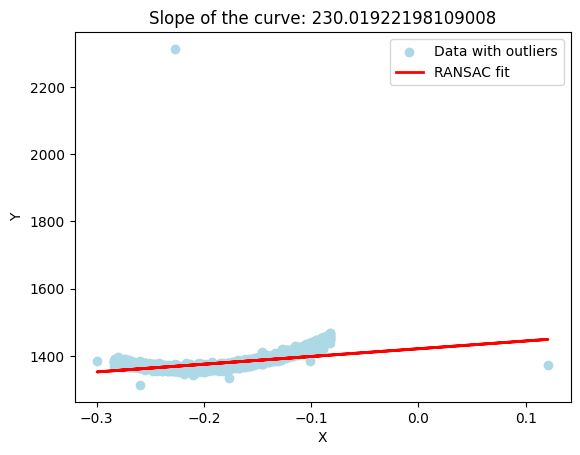

In [ ]:
# @title Implement Linear Regression to See the Relationship Between B values and Distance of peaks
from sklearn.linear_model import RANSACRegressor, LinearRegression
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Generate synthetic data with outliers
np.random.seed(42)

X = np.array(b_vals).reshape(-1,1)
y = diffs.reshape(-1,1)
# Create a RANSAC regressor
ransac = RANSACRegressor(LinearRegression(), min_samples=50, residual_threshold=10.0, random_state=42)
ransac.fit(X, y)
# Predict using the RANSAC model
y_pred = ransac.predict(X)

# Evaluate the model
mse = mean_squared_error(y, y_pred)
print(f"Mean Squared Error: {mse}")

residuals = y - y_pred
# Calculate residual sum of squares (RSS)
rss = np.sum(residuals ** 2)
# Calculate the residual variance
variance = rss / (len(y) - 1)
print(f"Variance: {variance}")
print(f'Correlaton coefficient: {np.corrcoef(np.squeeze(X), np.squeeze(y))}')

# Plot the results
plt.scatter(X, y, color='lightblue', label='Data with outliers')
plt.plot(X, ransac.predict(X), color='red', label='RANSAC fit', linewidth=2)
plt.title(f"Slope of the curve: {ransac.estimator_.coef_[0][0]}")
plt.xlabel("X")
plt.ylabel("Y")

plt.legend()
plt.show()

## Random Forest

In [ ]:
# @title Create datasets

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

peaks_scaled = torch.tensor(peaks_scaled).float()
b_vals = torch.tensor(b_vals).float()

x_train, x_test, y_train, y_test = train_test_split(peaks_scaled, b_vals , test_size=0.2 , random_state=21)

train_data = TensorDataset(x_train, y_train)
valid_data = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32)

In [ ]:
# @title Implement Random Forest
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

# Assume X is your 300-dim emission spectrum data and y is the corresponding magnetic field values
#x_train,x _test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Train a Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x_train_scaled, y_train)

# Predict on the test set
y_pred = model.predict(x_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"Absolute Error: {sum(abs(y_test - y_pred))/len(y_test)}")


Mean Squared Error: 0.0005960785882962796
Absolute Error: 0.017071493887637238


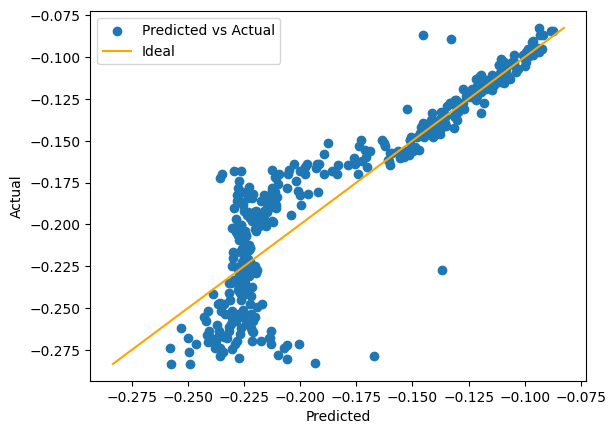

In [ ]:
plt.scatter(y_pred, y_test , label='Predicted vs Actual')
plt.plot(np.linspace(min(y_test),max(y_test), len(y_test)), np.linspace(min(y_test),max(y_test), len(y_test)), color='orange', label='Ideal')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend()

## XGBoost

Mean Squared Error: 0.0005287266103550792
Mean Squared Error: 0.015061072073876858


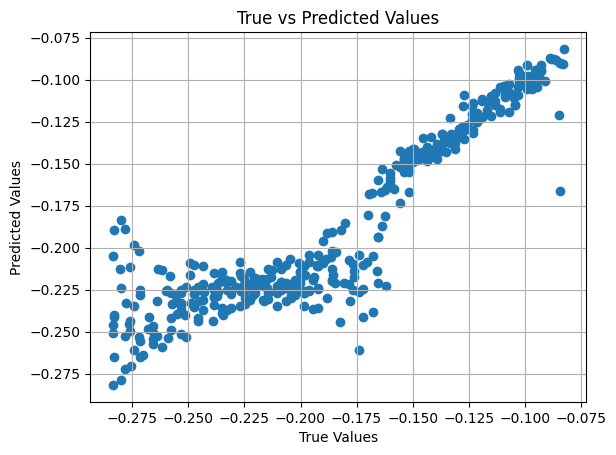

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Example: Load or create your dataset (X: emission spectra, y: target magnetic field values)
# X should be a 2D array with shape (n_samples, 1000), y should be a 1D array with shape (n_samples,)
# Replace the following lines with your actual data loading code
n_samples = 1000
X = peaks_scaled  # Replace with your 1000-dimensional emission spectra data
y = b_vals       # Replace with your scalar target values (e.g., magnetic field)

# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Create an XGBoost regression model
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)

# Step 3: Train the model on the training data
model.fit(X_train, y_train)

# Step 4: Make predictions on the test data
y_pred = model.predict(X_test)

# Step 5: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Squared Error: {sum(abs(y_test - y_pred))/len(y_test)}")
# Optionally: Plot predictions vs true values to visualize the performance
import matplotlib.pyplot as plt
plt.scatter(y_test, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("True vs Predicted Values")
plt.grid(True)
plt.show()



## Neural Networks

A basic ANN is constructed with ReLu in between the layers as the activation function.

In [ ]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.Relu = nn.ReLU()
    self.sigmoid = nn.Sigmoid()
    self.fc2 = nn.Linear(hidden_size,hidden_size)
    self.fc3 = nn.Linear(hidden_size, hidden_size)
    self.fc4 = nn.Linear(hidden_size, hidden_size)
    self.fc5 = nn.Linear(hidden_size,hidden_size)
    self.fc6 = nn.Linear(hidden_size,output_size)
    self.activation = nn.ReLU()

  def forward(self, x):
    x = self.activation(self.fc1(x))
    x = self.activation(self.fc2(x))
 #   x = self.activation(self.fc3(x))
#    x = self.activation(self.fc4(x))
 #   x = self.activation(self.fc5(x))
  #
    x = self.fc6(x)

    return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mlp_0 = MLP(len(peaks[0]), 256, 1).to(device)
mlp_0

MLP(
  (fc1): Linear(in_features=10000, out_features=256, bias=True)
  (Relu): ReLU()
  (sigmoid): Sigmoid()
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=256, bias=True)
  (fc5): Linear(in_features=256, out_features=256, bias=True)
  (fc6): Linear(in_features=256, out_features=1, bias=True)
  (activation): ReLU()
)

In [ ]:
# loss and optimization functions
lr = 0.00001

# Binary crossentropy is a good loss function for a binary classification problem
criterion = nn.MSELoss()

# We choose an Adam optimizer
optimizer = torch.optim.Adam(mlp_0.parameters(), lr=lr)


# Number of training Epochs
epochs = 300

Epoch 1
train_loss : 0.0047898231842555105 val_loss : 0.002755211048329679
train_accuracy : 48.09885931558935 val_accuracy : 48.860759493670884
Validation loss decreased (inf --> 0.002755).  Saving model ...
Epoch 2
train_loss : 0.003055361642036587 val_loss : 0.002550521883397148
train_accuracy : 49.93662864385298 val_accuracy : 48.860759493670884
Validation loss decreased (0.002755 --> 0.002551).  Saving model ...
Epoch 3
train_loss : 0.0028002996975556014 val_loss : 0.0023455774733939995
train_accuracy : 50.19011406844106 val_accuracy : 48.860759493670884
Validation loss decreased (0.002551 --> 0.002346).  Saving model ...
Epoch 4
train_loss : 0.002583387084305286 val_loss : 0.0021218834265779992
train_accuracy : 51.52091254752852 val_accuracy : 50.12658227848101
Validation loss decreased (0.002346 --> 0.002122).  Saving model ...
Epoch 5
train_loss : 0.0023883790895342827 val_loss : 0.0021156332133194576
train_accuracy : 54.372623574144484 val_accuracy : 64.55696202531645
Validatio

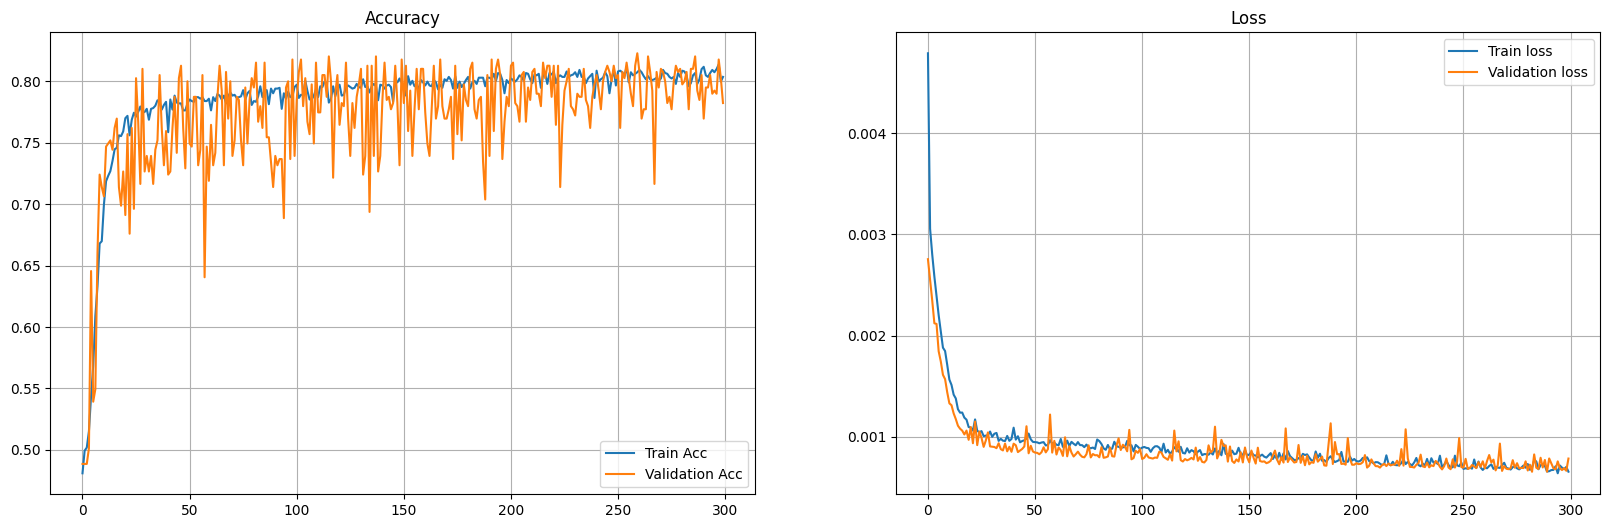

In [ ]:
epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss , y_preds , y_labels= train_model(mlp_0, train_loader, valid_loader, epochs, criterion, optimizer,  device=device)
plot_loss_acc(epoch_tr_acc, epoch_vl_acc, epoch_tr_loss, epoch_vl_loss)

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
print(r2_score(torch.cat(y_labels).cpu().detach().numpy(), torch.cat(y_preds).cpu().detach().numpy()))
print(f"Mean squared error: {mean_squared_error(torch.cat(y_labels).cpu().detach().numpy(), torch.cat(y_preds).cpu().detach().numpy())}")
print(f"Mean error is: {sum(abs(torch.cat(y_preds) - torch.cat(y_labels)))/len(y_test)}")

0.7483949661254883
Mean squared error: 0.0007799643790349364
Mean error is: 0.021720902994275093


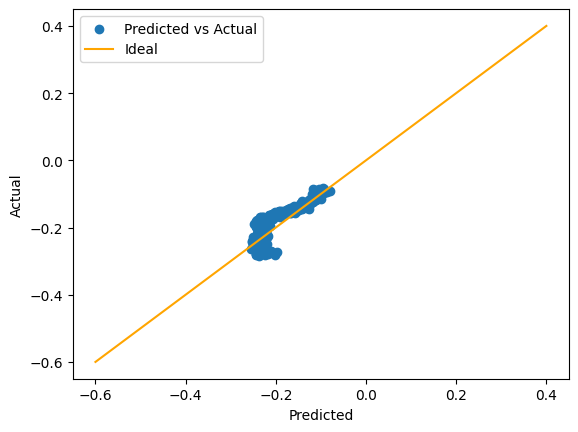

In [ ]:
plt.scatter(torch.cat(y_preds).cpu().detach().numpy(), torch.cat(y_labels).cpu().detach().numpy() , label='Predicted vs Actual')
plt.plot(np.linspace(-0.6,0.4, len(y_labels)),np.linspace(-0.6,0.4, len(y_labels)), color='orange', label='Ideal')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend()